# Assignment 1: Sampler Synthesis — Starter Code

This notebook provides baseline implementations of Random Walk Metropolis-Hastings and HMC using [BlackJAX](https://blackjax-devs.github.io/blackjax/). Use these as reference points for your novel sampler.

**Your task**: Design, implement, and analyze a novel MCMC sampler. Compare it to these baselines on the benchmark distributions.

In [1]:
import arviz as az
import blackjax
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["font.size"] = 12

---
## Benchmark Distribution: Rosenbrock (Banana)

The Rosenbrock distribution has a curved, narrow ridge that tests how well samplers handle strong correlations and curved geometry. This is challenging because:
- The high-probability region is thin and curved
- Random walk proposals often step off the ridge
- Samplers need to follow the curved geometry efficiently

In [2]:
def log_prob_rosenbrock(theta):
    """Rosenbrock (banana) distribution.

    log p(x, y) ∝ -(1-x)²/20 - (y - x²)²

    This creates a curved, banana-shaped distribution that tests
    how well samplers handle strong correlations and curved geometry.
    """
    x, y = theta[0], theta[1]
    return -0.05 * (1 - x) ** 2 - (y - x**2) ** 2

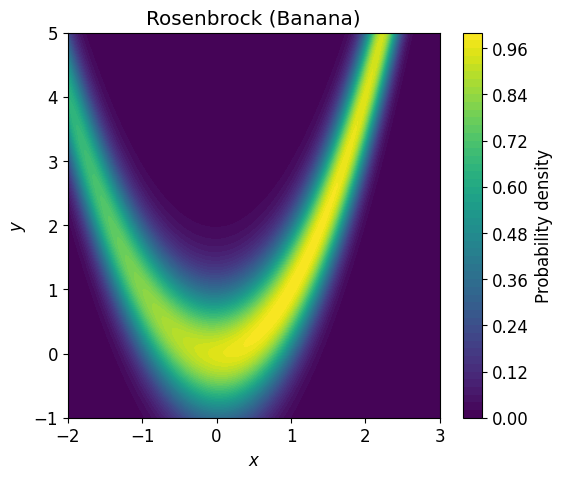

In [3]:
def plot_distribution(log_prob_fn, title, xlim=(-4, 4), ylim=(-4, 4)):
    """Visualize a 2D log probability distribution."""
    x = jnp.linspace(*xlim, 200)
    y = jnp.linspace(*ylim, 200)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)

    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    plt.figure(figsize=(6, 5))
    plt.contourf(X, Y, jnp.exp(log_probs), levels=50, cmap="viridis")
    plt.colorbar(label="Probability density")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.title(title)
    plt.show()


plot_distribution(log_prob_rosenbrock, "Rosenbrock (Banana)", xlim=(-2, 3), ylim=(-1, 5))

---
## Baseline 1: Random Walk Metropolis-Hastings

The simplest MCMC method. Proposes isotropic Gaussian steps — no gradient information.

**Tuning tip:** Target ~23-50% acceptance rate. Higher isn't better — it means steps are too small.

In [4]:
def run_rwmh(key, log_prob_fn, initial_position, sigma, n_samples):
    """Run Random Walk Metropolis-Hastings using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        sigma: Proposal standard deviation (scalar or array)
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler with a normal proposal distribution
    rmh = blackjax.rmh(log_prob_fn, blackjax.mcmc.random_walk.normal(sigma))
    initial_state = rmh.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = rmh.step(key, state)
        return state, (state.position, info.is_accepted)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Baseline 2: Hamiltonian Monte Carlo (HMC)

Uses gradient information to make informed proposals. Typically much more efficient than random walk.

**Tuning tip:** Target ~65-90% acceptance rate. Tune step_size first, then n_leapfrog.

In [5]:
def run_hmc(key, log_prob_fn, initial_position, step_size, n_leapfrog, n_samples):
    """Run HMC using BlackJAX.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Leapfrog step size (epsilon)
        n_leapfrog: Number of leapfrog steps per iteration
        n_samples: Number of samples to draw

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    # Initialize the sampler (identity mass matrix)
    inverse_mass_matrix = jnp.ones(initial_position.shape[0])
    hmc = blackjax.hmc(
        log_prob_fn,
        step_size=step_size,
        inverse_mass_matrix=inverse_mass_matrix,
        num_integration_steps=n_leapfrog,
    )
    initial_state = hmc.init(initial_position)

    # Build the sampling loop
    @jax.jit
    def one_step(state, key):
        state, info = hmc.step(key, state)
        return state, (state.position, info.acceptance_rate)

    # Run the chain
    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(one_step, initial_state, keys)

    return samples, accepted.mean()

---
## Run Baselines on Rosenbrock

In [6]:
key = jr.PRNGKey(42)
key1, key2 = jr.split(key)

initial_pos = jnp.array([0.0, 0.0])
n_samples = 50_000

# Random Walk MH
rwmh_samples, rwmh_acc = run_rwmh(key1, log_prob_rosenbrock, initial_pos, sigma=1.0, n_samples=n_samples)
print(f"RWMH acceptance rate: {rwmh_acc:.2%}")

# HMC
hmc_samples, hmc_acc = run_hmc(
    key2, log_prob_rosenbrock, initial_pos, step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate: {hmc_acc:.2%}")

RWMH acceptance rate: 50.02%
HMC acceptance rate: 74.78%


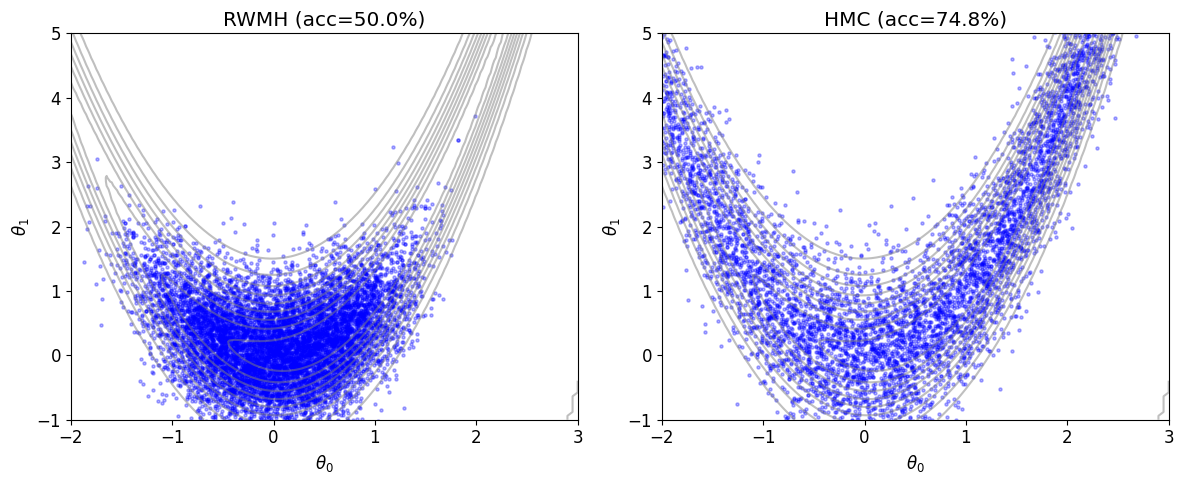

In [7]:
def plot_samples_comparison(samples1, samples2, label1, label2, log_prob_fn, xlim, ylim):
    """Plot samples from two methods side by side."""
    # Compute contours
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, samples, label in zip(axes, [samples1, samples2], [label1, label2]):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    plt.tight_layout()
    plt.show()


plot_samples_comparison(
    rwmh_samples,
    hmc_samples,
    f"RWMH (acc={rwmh_acc:.1%})",
    f"HMC (acc={hmc_acc:.1%})",
    log_prob_rosenbrock,
    xlim=(-2, 3),
    ylim=(-1, 5),
)

---
## Diagnostics with ArviZ

[ArviZ](https://python.arviz.org/) provides standard MCMC diagnostics. Key metrics:
- **Acceptance rate**: Too low = proposals too aggressive; too high = proposals too timid
- **Effective Sample Size (ESS)**: How many independent samples you effectively have
- **Trace plots**: Visual check for mixing and stationarity
- **Autocorrelation**: How correlated successive samples are

In [8]:
def samples_to_inference_data(samples, var_names=None):
    """Convert samples array to ArviZ InferenceData.

    Args:
        samples: Array of shape (n_samples, n_dims)
        var_names: Optional list of variable names

    Returns:
        ArviZ InferenceData object
    """
    if var_names is None:
        var_names = [f"theta_{i}" for i in range(samples.shape[1])]

    # ArviZ expects dict of {var_name: array} with shape (n_chains, n_samples)
    data_dict = {name: samples[None, :, i] for i, name in enumerate(var_names)}
    return az.convert_to_inference_data(data_dict)


def summarize_sampler(samples, name, var_names=None):
    """Print summary statistics for samples using ArviZ."""
    idata = samples_to_inference_data(samples, var_names)
    print(f"\n=== {name} ===")
    display(az.summary(idata, kind="stats"))

In [9]:
# Rosenbrock diagnostics
var_names = ["x", "y"]

rwmh_idata = samples_to_inference_data(rwmh_samples, var_names)
hmc_idata = samples_to_inference_data(hmc_samples, var_names)

# Summary statistics (mean, sd, ESS)
summarize_sampler(rwmh_samples, "RWMH — Rosenbrock", var_names)
summarize_sampler(hmc_samples, "HMC — Rosenbrock", var_names)


=== RWMH — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC — Rosenbrock ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324


RWMH Trace Plots:


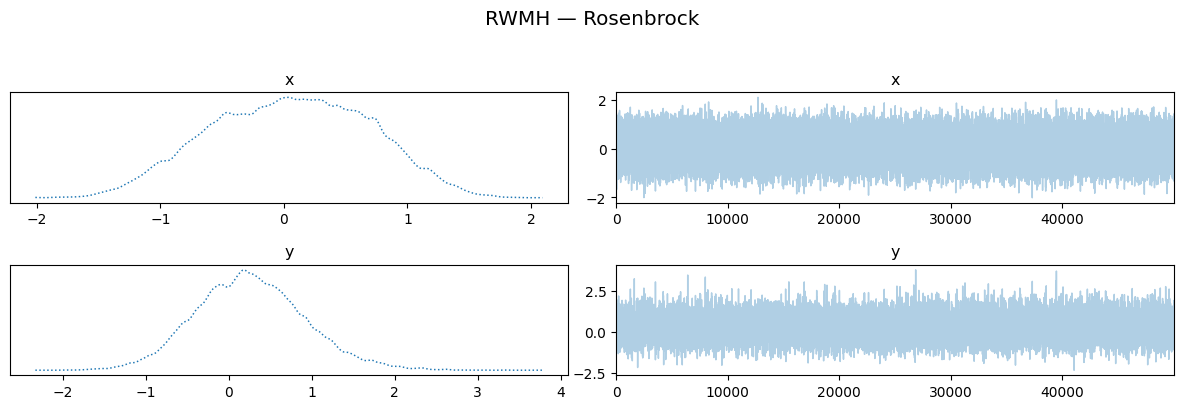


HMC Trace Plots:


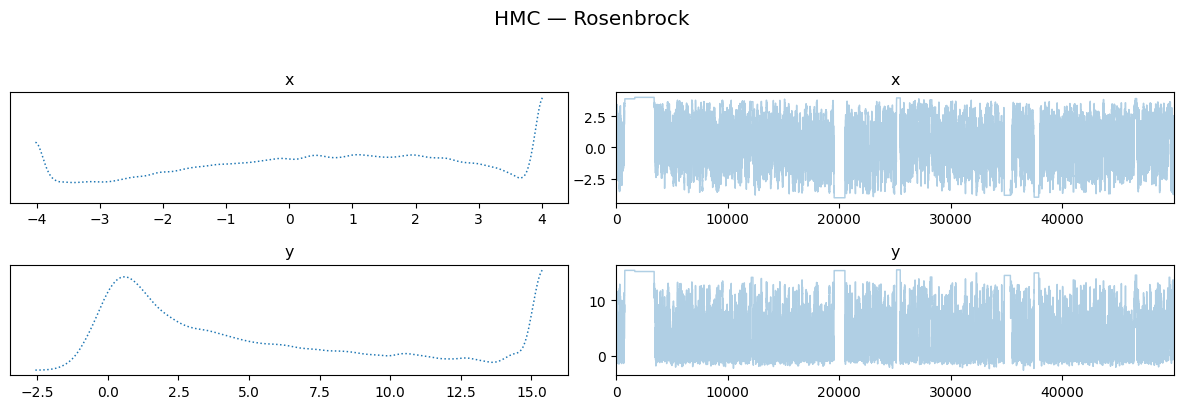

In [10]:
# Trace plots — Rosenbrock
print("RWMH Trace Plots:")
az.plot_trace(rwmh_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

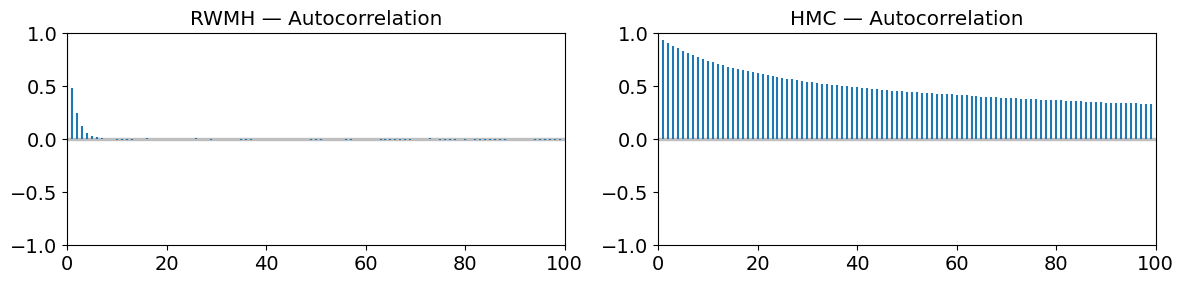

In [11]:
# Autocorrelation — Rosenbrock
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Discussion: Why Does RWMH Struggle Here?

Look carefully at the results above. You might notice something surprising: RWMH has *lower* autocorrelation than HMC, yet HMC explores the distribution much better. What's going on?

**The issue is local vs. global mixing.** RWMH with isotropic proposals faces a dilemma on curved distributions like the Rosenbrock:
- If the proposal scale is small enough to stay on the narrow ridge, it can't move far along the banana
- If the proposal scale is large enough to explore, most proposals step off the ridge and get rejected

So RWMH ends up jittering locally — samples decorrelate quickly *within* its local neighborhood, but it never traverses the full banana. Low autocorrelation doesn't mean good exploration!

**HMC uses gradients to follow the curve.** It makes long, coherent moves along the ridge without stepping off. The high autocorrelation is just because consecutive samples are along the same trajectory — but they're actually covering the full posterior.

This is exactly the kind of geometry where HMC shines, and one of the main motivations for gradient-based samplers.

---
## Benchmark Distribution 2: Neal's Funnel

Neal's Funnel is a hierarchical distribution that varies dramatically in scale across the space. The narrow "neck" of the funnel is notoriously difficult for fixed step-size samplers.

$$v \sim \mathcal{N}(0, 9), \quad x \sim \mathcal{N}(0, e^v)$$

This means:
- When $v$ is large and positive, $x$ can vary widely
- When $v$ is large and negative, $x$ is tightly constrained near 0
- A single step size can't work well everywhere

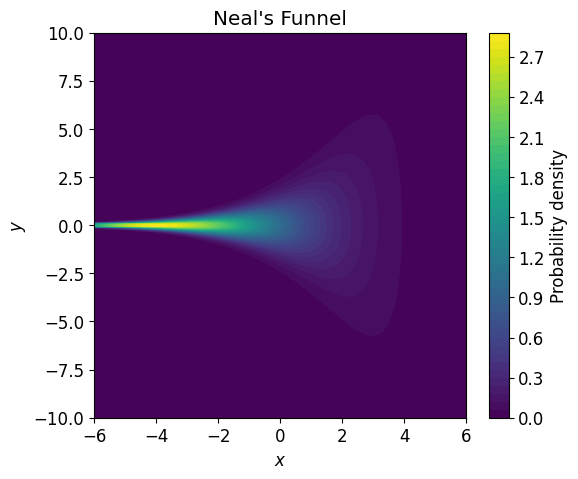

In [12]:
def log_prob_funnel(theta):
    """Neal's Funnel distribution.

    v ~ N(0, 9)
    x ~ N(0, exp(v))

    This creates a funnel shape where the scale of x depends on v.
    The narrow neck (small v) is very hard to sample.
    """
    v, x = theta[0], theta[1]
    log_p_v = -0.5 * v**2 / 9  # v ~ N(0, 9)
    log_p_x_given_v = -0.5 * x**2 * jnp.exp(-v) - 0.5 * v  # x ~ N(0, exp(v))
    return log_p_v + log_p_x_given_v


plot_distribution(log_prob_funnel, "Neal's Funnel", xlim=(-6, 6), ylim=(-10, 10))

RWMH acceptance rate (Funnel): 73.29%
HMC acceptance rate (Funnel): 90.94%


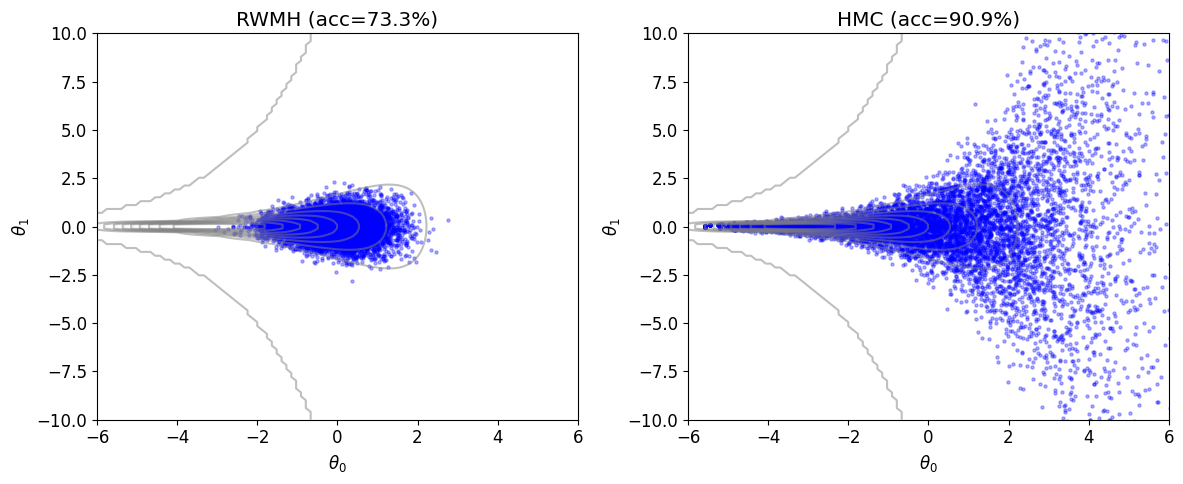


=== RWMH — Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,-0.169,0.75,-1.581,1.24
x,-0.001,0.60,-1.178,1.09



=== HMC — Funnel ===


,mean,sd,hdi_3%,hdi_97%
v,0.363,3.111,-5.578,5.655
x,2.720,14.362,-10.881,19.390


RWMH Trace Plots:


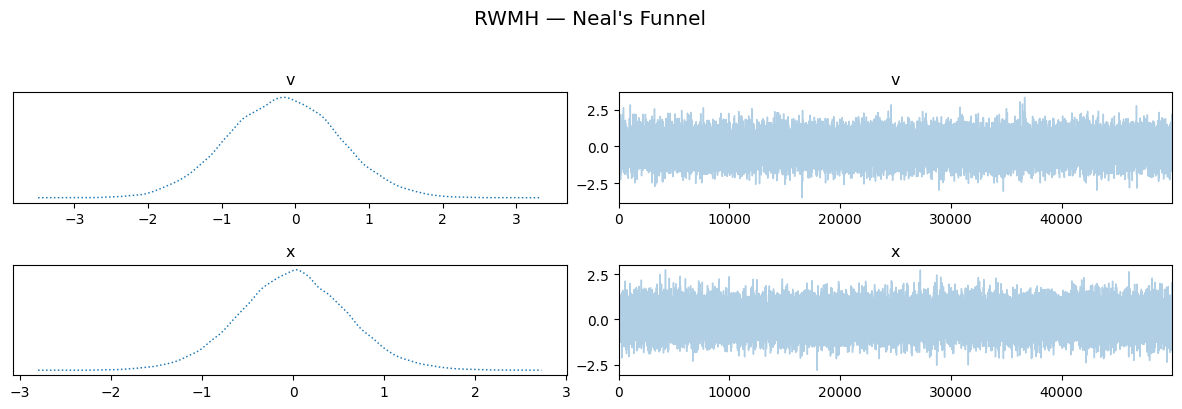


HMC Trace Plots:


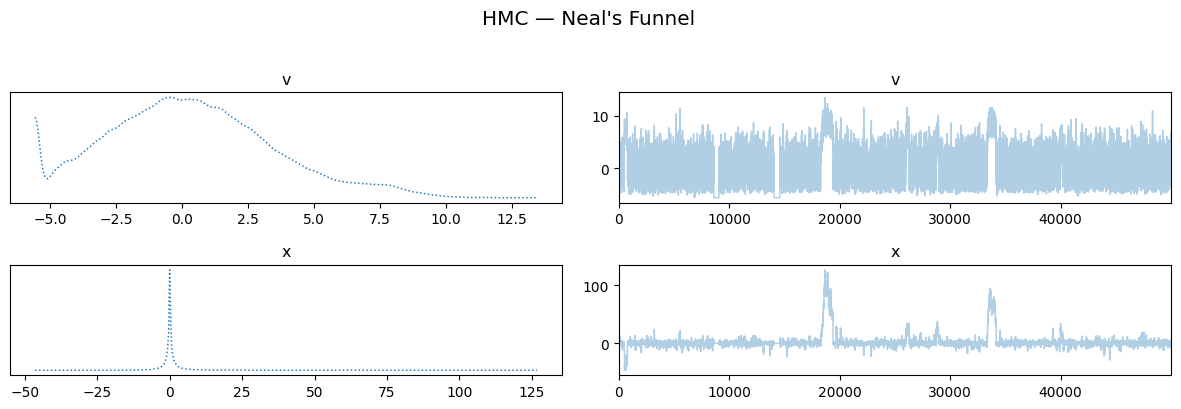

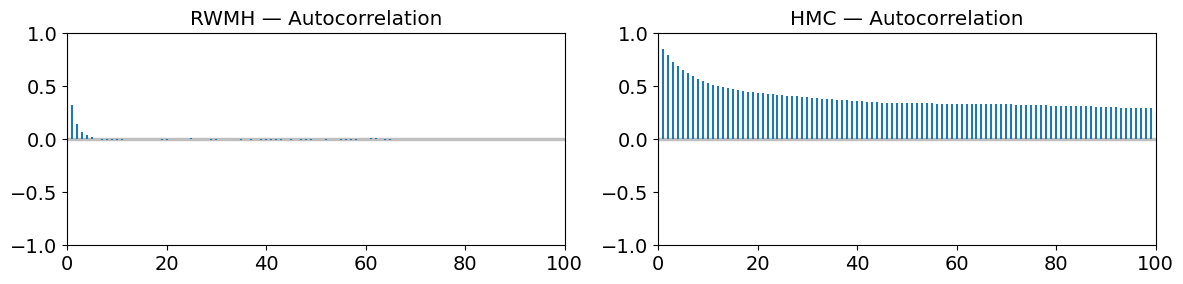

In [13]:
key_funnel = jr.PRNGKey(123)
k1, k2 = jr.split(key_funnel)

initial_pos_funnel = jnp.array([0.0, 0.0])

# RWMH on Funnel
rwmh_funnel_samples, rwmh_funnel_acc = run_rwmh(
    k1, log_prob_funnel, initial_pos_funnel, sigma=0.8, n_samples=n_samples
)
print(f"RWMH acceptance rate (Funnel): {rwmh_funnel_acc:.2%}")

# HMC on Funnel — fixed step size is a fundamental limitation here
hmc_funnel_samples, hmc_funnel_acc = run_hmc(
    k2, log_prob_funnel, initial_pos_funnel,
    step_size=0.2, n_leapfrog=10, n_samples=n_samples
)
print(f"HMC acceptance rate (Funnel): {hmc_funnel_acc:.2%}")

plot_samples_comparison(
    rwmh_funnel_samples, hmc_funnel_samples,
    f"RWMH (acc={rwmh_funnel_acc:.1%})",
    f"HMC (acc={hmc_funnel_acc:.1%})",
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10)
)

# Diagnostics
var_names_funnel = ["v", "x"]
rwmh_funnel_idata = samples_to_inference_data(rwmh_funnel_samples, var_names_funnel)
hmc_funnel_idata = samples_to_inference_data(hmc_funnel_samples, var_names_funnel)

summarize_sampler(rwmh_funnel_samples, "RWMH — Funnel", var_names_funnel)
summarize_sampler(hmc_funnel_samples, "HMC — Funnel", var_names_funnel)

# Trace plots
print("RWMH Trace Plots:")
az.plot_trace(rwmh_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("RWMH — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

print("\nHMC Trace Plots:")
az.plot_trace(hmc_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("HMC — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

# Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
az.plot_autocorr(rwmh_funnel_idata, ax=axes[0], combined=True)
axes[0].set_title("RWMH — Autocorrelation")
az.plot_autocorr(hmc_funnel_idata, ax=axes[1], combined=True)
axes[1].set_title("HMC — Autocorrelation")
plt.tight_layout()
plt.show()

---
## Your Novel Sampler

Now it's your turn! Implement your own sampler below. Some ideas:

- **Adaptive proposals**: Adjust step size based on acceptance rate or local curvature
- **Hybrid methods**: Combine different move types (e.g., local + global moves)
- **Modified dynamics**: Change the Hamiltonian, use different integrators, add friction
- **Tempering**: Use temperature schedules to help exploration

A simple idea with thorough analysis beats a complex idea you don't understand!

### Hessian-Preconditioned MALA (HP-MALA)

**Motivation.** RWMH ignores gradient information entirely, leading to diffusive exploration. Standard HMC and MALA use gradients but rely on a *fixed* mass matrix (or identity preconditioning), which fails when the target geometry varies across the space — as in the Rosenbrock's curved ridge or the Funnel's scale-varying neck.

**Key idea.** At each position $\theta$, we compute the Hessian $\nabla^2 \log p(\theta)$ and use the regularized negative Hessian $G(\theta) = \text{clip}(-\nabla^2 \log p(\theta), \delta)$ as a *position-dependent metric tensor*. This metric captures the local curvature: eigenvalues of $G$ are large in directions of high curvature (constraining proposals) and small in directions of low curvature (allowing larger steps).

**Algorithm.**
1. Compute gradient $g = \nabla \log p(\theta)$ and Hessian $H = \nabla^2 \log p(\theta)$
2. Eigendecompose $-H = U \Lambda U^\top$; clip eigenvalues: $\lambda_i \leftarrow \max(\lambda_i, \delta)$
3. Propose: $\theta' \sim \mathcal{N}\!\left(\theta + \frac{\varepsilon^2}{2} G^{-1} g,\; \varepsilon^2 G^{-1}\right)$
4. Accept/reject with MH ratio that corrects for the asymmetric, position-dependent proposal:
$$\alpha = \min\!\left(1,\; \frac{p(\theta')\, q(\theta \mid \theta')}{p(\theta)\, q(\theta' \mid \theta)}\right)$$

**Why this should work well:**
- **Rosenbrock:** The Hessian captures the curved ridge geometry, stretching proposals along the ridge and constraining them across it.
- **Neal's Funnel:** In the narrow neck ($v \ll 0$), the Hessian eigenvalue for $x$ is $e^{-v} \gg 1$, automatically shrinking $x$-proposals. In the wide region ($v \gg 0$), it is $e^{-v} \ll 1$ (clipped to $\delta$), allowing large $x$-steps.

In [14]:
def run_hpmala(key, log_prob_fn, initial_position, step_size, n_samples, delta=0.1):
    """Hessian-Preconditioned Metropolis-Adjusted Langevin Algorithm.

    Uses the local Hessian of the log-density to construct a position-
    dependent metric tensor, adapting proposal shape and scale to the
    local curvature of the target distribution at each step.

    Args:
        key: JAX random key
        log_prob_fn: Log probability function
        initial_position: Starting point, shape (D,)
        step_size: Global step size (epsilon)
        n_samples: Number of samples to draw
        delta: Floor on eigenvalues of -Hessian for regularization

    Returns:
        samples: Array of shape (n_samples, D)
        acceptance_rate: Fraction of accepted proposals
    """
    dim = initial_position.shape[0]
    grad_fn = jax.grad(log_prob_fn)
    hess_fn = jax.hessian(log_prob_fn)

    def local_geometry(theta):
        g = grad_fn(theta)
        H = hess_fn(theta)
        eigvals, eigvecs = jnp.linalg.eigh(-H)
        eigvals = jnp.maximum(eigvals, delta)
        mu = theta + 0.5 * step_size**2 * eigvecs @ (eigvecs.T @ g / eigvals)
        return mu, eigvals, eigvecs

    def log_q(x, mu, eigvals, eigvecs):
        """Log proposal density N(mu, eps^2 * G^{-1})."""
        Qtd = eigvecs.T @ (x - mu)
        return -0.5 / step_size**2 * jnp.sum(eigvals * Qtd**2) + 0.5 * jnp.sum(jnp.log(eigvals))

    def step(theta, rng):
        k1, k2 = jr.split(rng)
        # Forward proposal
        mu_f, ev_f, U_f = local_geometry(theta)
        theta_p = mu_f + step_size * U_f @ (jr.normal(k1, (dim,)) / jnp.sqrt(ev_f))
        # Reverse geometry for MH correction
        mu_r, ev_r, U_r = local_geometry(theta_p)
        # Log MH ratio including position-dependent proposal asymmetry
        log_a = (log_prob_fn(theta_p) - log_prob_fn(theta)
                + log_q(theta, mu_r, ev_r, U_r)
                - log_q(theta_p, mu_f, ev_f, U_f))
        log_a = jnp.where(jnp.isfinite(log_a), log_a, -jnp.inf)
        accept = jnp.log(jr.uniform(k2)) < jnp.minimum(log_a, 0.0)
        new_theta = jnp.where(accept, theta_p, theta)
        return new_theta, (new_theta, accept)

    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(step, initial_position, keys)
    return samples, accepted.mean()


def run_mala(key, log_prob_fn, initial_position, step_size, n_samples):
    """Standard MALA with identity preconditioning (ablation baseline)."""
    dim = initial_position.shape[0]
    grad_fn = jax.grad(log_prob_fn)

    def step(theta, rng):
        k1, k2 = jr.split(rng)
        g = grad_fn(theta)
        mu_f = theta + 0.5 * step_size**2 * g
        theta_p = mu_f + step_size * jr.normal(k1, (dim,))
        g_p = grad_fn(theta_p)
        mu_r = theta_p + 0.5 * step_size**2 * g_p
        fwd = -0.5 / step_size**2 * jnp.sum((theta_p - mu_f)**2)
        rev = -0.5 / step_size**2 * jnp.sum((theta - mu_r)**2)
        log_a = log_prob_fn(theta_p) - log_prob_fn(theta) + rev - fwd
        log_a = jnp.where(jnp.isfinite(log_a), log_a, -jnp.inf)
        accept = jnp.log(jr.uniform(k2)) < jnp.minimum(log_a, 0.0)
        new_theta = jnp.where(accept, theta_p, theta)
        return new_theta, (new_theta, accept)

    keys = jr.split(key, n_samples)
    _, (samples, accepted) = jax.lax.scan(step, initial_position, keys)
    return samples, accepted.mean()

In [15]:
key_hp = jr.PRNGKey(42)
k1, k2 = jr.split(key_hp)

# HP-MALA on Rosenbrock (eps=1.0 targets ~60% acceptance)
hpmala_rosa_samples, hpmala_rosa_acc = run_hpmala(
    k1, log_prob_rosenbrock, initial_pos,
    step_size=1.0, n_samples=n_samples, delta=0.1
)
print(f"HP-MALA acceptance rate (Rosenbrock): {hpmala_rosa_acc:.2%}")

# HP-MALA on Neal's Funnel (eps=0.5 targets ~57% acceptance)
hpmala_funnel_samples, hpmala_funnel_acc = run_hpmala(
    k2, log_prob_funnel, initial_pos_funnel,
    step_size=0.5, n_samples=n_samples, delta=0.1
)
print(f"HP-MALA acceptance rate (Funnel): {hpmala_funnel_acc:.2%}")

HP-MALA acceptance rate (Rosenbrock): 58.50%
HP-MALA acceptance rate (Funnel): 57.00%


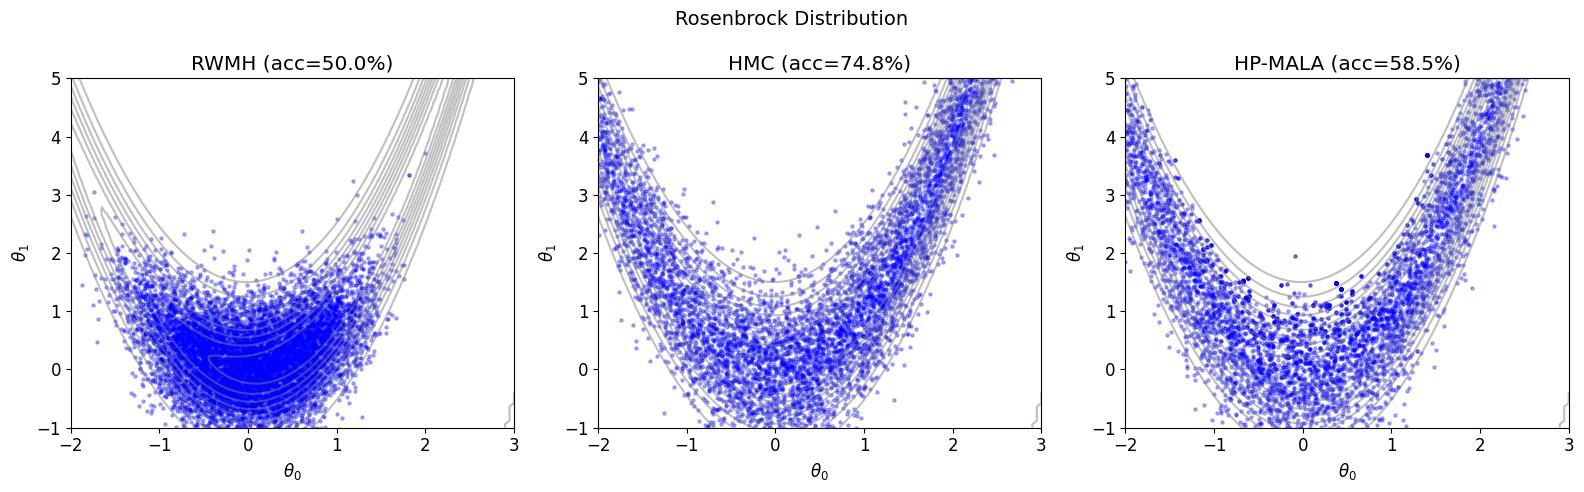

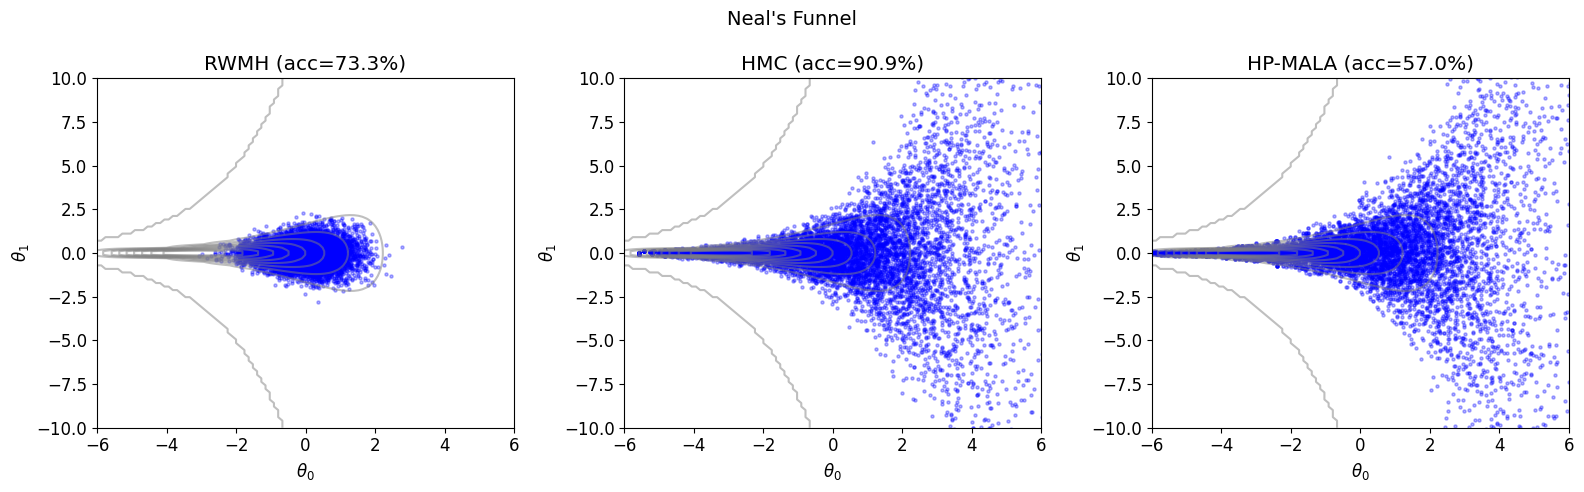

=== Effective Sample Size Comparison ===

--- Rosenbrock ---

=== RWMH ===


,mean,sd,hdi_3%,hdi_97%
x,0.048,0.637,-1.105,1.206
y,0.266,0.659,-0.982,1.497



=== HMC ===


,mean,sd,hdi_3%,hdi_97%
x,0.456,2.202,-3.390,4.018
y,4.970,5.012,-0.379,15.324



=== HP-MALA ===


,mean,sd,hdi_3%,hdi_97%
x,0.351,2.873,-5.075,5.823
y,8.365,11.549,-1.614,30.719



--- Neal's Funnel ---

=== RWMH ===


,mean,sd,hdi_3%,hdi_97%
v,-0.169,0.75,-1.581,1.24
x,-0.001,0.60,-1.178,1.09



=== HMC ===


,mean,sd,hdi_3%,hdi_97%
v,0.363,3.111,-5.578,5.655
x,2.720,14.362,-10.881,19.390



=== HP-MALA ===


,mean,sd,hdi_3%,hdi_97%
v,0.167,3.208,-5.633,6.586
x,1.582,7.836,-10.784,15.949



HP-MALA Trace Plots (Rosenbrock):


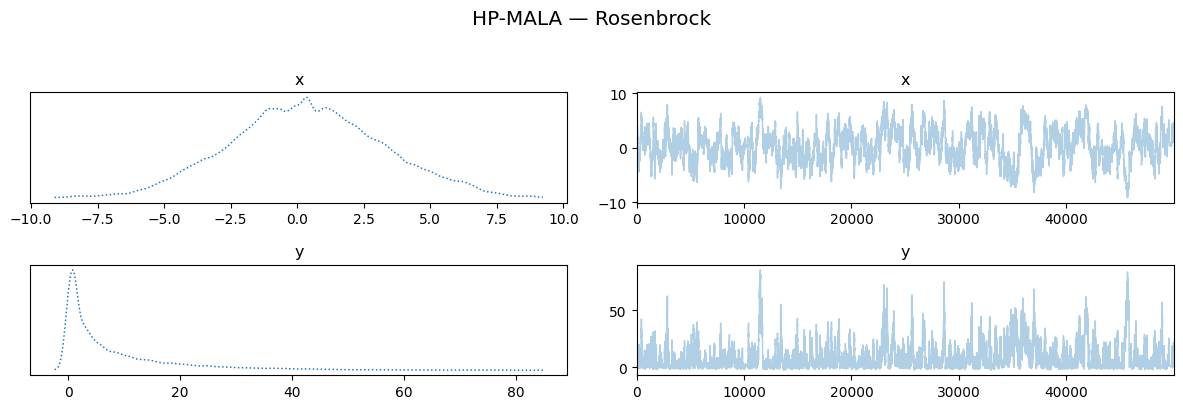


HP-MALA Trace Plots (Funnel):


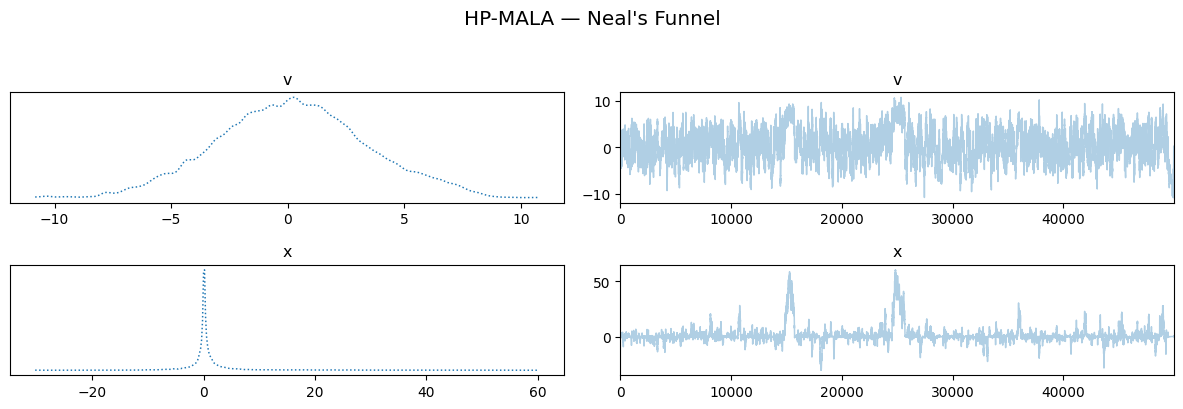

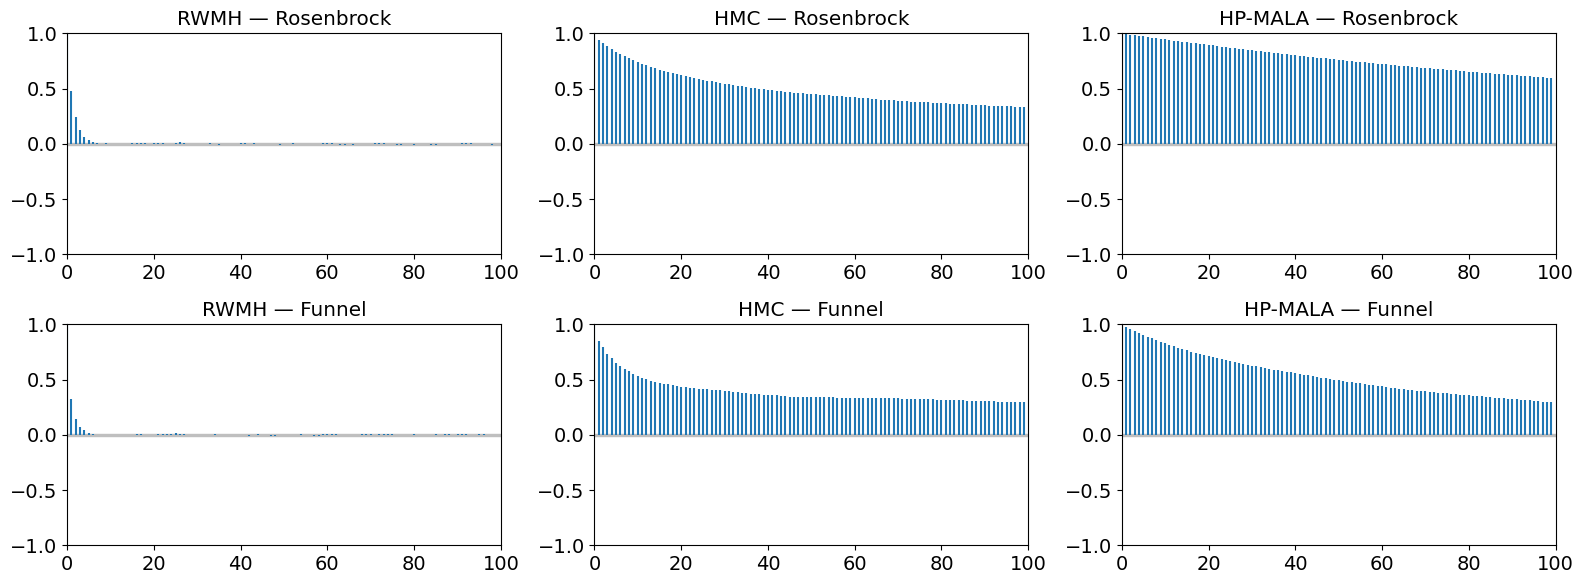

In [16]:
def plot_three_way(samples_list, labels, log_prob_fn, xlim, ylim, title):
    """Three-way scatter plot comparison."""
    x = jnp.linspace(*xlim, 100)
    y = jnp.linspace(*ylim, 100)
    X, Y = jnp.meshgrid(x, y)
    positions = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
    log_probs = jax.vmap(log_prob_fn)(positions).reshape(X.shape)

    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for ax, samples, label in zip(axes, samples_list, labels):
        ax.contour(X, Y, jnp.exp(log_probs), levels=10, colors="gray", alpha=0.5)
        ax.scatter(samples[::5, 0], samples[::5, 1], alpha=0.3, s=5, c="blue")
        ax.set_xlabel(r"$\theta_0$")
        ax.set_ylabel(r"$\theta_1$")
        ax.set_title(label)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# --- Rosenbrock: three-way comparison ---
plot_three_way(
    [rwmh_samples, hmc_samples, hpmala_rosa_samples],
    [f"RWMH (acc={rwmh_acc:.1%})", f"HMC (acc={hmc_acc:.1%})",
     f"HP-MALA (acc={hpmala_rosa_acc:.1%})"],
    log_prob_rosenbrock, xlim=(-2, 3), ylim=(-1, 5),
    title="Rosenbrock Distribution"
)

# --- Funnel: three-way comparison ---
plot_three_way(
    [rwmh_funnel_samples, hmc_funnel_samples, hpmala_funnel_samples],
    [f"RWMH (acc={rwmh_funnel_acc:.1%})", f"HMC (acc={hmc_funnel_acc:.1%})",
     f"HP-MALA (acc={hpmala_funnel_acc:.1%})"],
    log_prob_funnel, xlim=(-6, 6), ylim=(-10, 10),
    title="Neal's Funnel"
)

# --- ESS comparison ---
print("=== Effective Sample Size Comparison ===")

hpmala_rosa_idata = samples_to_inference_data(hpmala_rosa_samples, var_names)
hpmala_funnel_idata = samples_to_inference_data(hpmala_funnel_samples, var_names_funnel)

print("\n--- Rosenbrock ---")
summarize_sampler(rwmh_samples, "RWMH", var_names)
summarize_sampler(hmc_samples, "HMC", var_names)
summarize_sampler(hpmala_rosa_samples, "HP-MALA", var_names)

print("\n--- Neal's Funnel ---")
summarize_sampler(rwmh_funnel_samples, "RWMH", var_names_funnel)
summarize_sampler(hmc_funnel_samples, "HMC", var_names_funnel)
summarize_sampler(hpmala_funnel_samples, "HP-MALA", var_names_funnel)

# --- HP-MALA trace plots ---
print("\nHP-MALA Trace Plots (Rosenbrock):")
az.plot_trace(hpmala_rosa_idata, combined=True, figsize=(12, 4))
plt.suptitle("HP-MALA — Rosenbrock", y=1.02)
plt.tight_layout()
plt.show()

print("\nHP-MALA Trace Plots (Funnel):")
az.plot_trace(hpmala_funnel_idata, combined=True, figsize=(12, 4))
plt.suptitle("HP-MALA — Neal's Funnel", y=1.02)
plt.tight_layout()
plt.show()

# --- Autocorrelation comparison ---
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for j, (idata, name) in enumerate([
    (rwmh_idata, "RWMH"), (hmc_idata, "HMC"), (hpmala_rosa_idata, "HP-MALA")
]):
    az.plot_autocorr(idata, ax=axes[0, j], combined=True)
    axes[0, j].set_title(f"{name} — Rosenbrock")
for j, (idata, name) in enumerate([
    (rwmh_funnel_idata, "RWMH"), (hmc_funnel_idata, "HMC"),
    (hpmala_funnel_idata, "HP-MALA")
]):
    az.plot_autocorr(idata, ax=axes[1, j], combined=True)
    axes[1, j].set_title(f"{name} — Funnel")
plt.tight_layout()
plt.show()

In [17]:
# Ablation 1: Step size sensitivity
print("=== Ablation 1: Step Size Sensitivity ===\n")
key_abl = jr.PRNGKey(99)

print("Rosenbrock:")
for eps in [0.2, 0.5, 0.7, 1.0, 1.5]:
    s, a = run_hpmala(key_abl, log_prob_rosenbrock, initial_pos,
                      step_size=eps, n_samples=n_samples, delta=0.1)
    idata = samples_to_inference_data(s, var_names)
    ess = az.ess(idata)
    print(f"  eps={eps:.1f}: acc={float(a):.2%}, "
          f"ESS_x={float(ess['x'].values):.0f}, "
          f"ESS_y={float(ess['y'].values):.0f}")

print("\nNeal's Funnel:")
for eps in [0.1, 0.2, 0.3, 0.5, 0.7]:
    s, a = run_hpmala(key_abl, log_prob_funnel, initial_pos_funnel,
                      step_size=eps, n_samples=n_samples, delta=0.1)
    idata = samples_to_inference_data(s, var_names_funnel)
    ess = az.ess(idata)
    print(f"  eps={eps:.1f}: acc={float(a):.2%}, "
          f"ESS_v={float(ess['v'].values):.0f}, "
          f"ESS_x={float(ess['x'].values):.0f}")


# Ablation 2: Regularization strength (delta)

print("\n=== Ablation 2: Regularization Strength (delta) ===\n")

print("Rosenbrock (eps=0.7):")
for d in [0.01, 0.05, 0.1, 0.5, 1.0, 10.0]:
    s, a = run_hpmala(key_abl, log_prob_rosenbrock, initial_pos,
                      step_size=0.7, n_samples=n_samples, delta=d)
    idata = samples_to_inference_data(s, var_names)
    ess = az.ess(idata)
    print(f"  delta={d:5.2f}: acc={float(a):.2%}, "
          f"ESS_x={float(ess['x'].values):.0f}, "
          f"ESS_y={float(ess['y'].values):.0f}")

print("\nNeal's Funnel (eps=0.3):")
for d in [0.01, 0.05, 0.1, 0.5, 1.0, 10.0]:
    s, a = run_hpmala(key_abl, log_prob_funnel, initial_pos_funnel,
                      step_size=0.3, n_samples=n_samples, delta=d)
    idata = samples_to_inference_data(s, var_names_funnel)
    ess = az.ess(idata)
    print(f"  delta={d:5.2f}: acc={float(a):.2%}, "
          f"ESS_v={float(ess['v'].values):.0f}, "
          f"ESS_x={float(ess['x'].values):.0f}")


# Ablation 3: HP-MALA vs standard MALA (removing Hessian)

print("\n=== Ablation 3: HP-MALA vs Standard MALA ===\n")

print("Rosenbrock:")
for eps in [0.3, 0.5, 0.7]:
    s1, a1 = run_hpmala(key_abl, log_prob_rosenbrock, initial_pos,
                        step_size=eps, n_samples=n_samples, delta=0.1)
    ess1 = az.ess(samples_to_inference_data(s1, var_names))
    s2, a2 = run_mala(key_abl, log_prob_rosenbrock, initial_pos,
                      step_size=eps, n_samples=n_samples)
    ess2 = az.ess(samples_to_inference_data(s2, var_names))
    print(f"  eps={eps:.1f}:  HP-MALA acc={float(a1):.2%} ESS_x={float(ess1['x'].values):5.0f}"
          f"  |  MALA acc={float(a2):.2%} ESS_x={float(ess2['x'].values):5.0f}")

print("\nNeal's Funnel:")
for eps in [0.1, 0.2, 0.3]:
    s1, a1 = run_hpmala(key_abl, log_prob_funnel, initial_pos_funnel,
                        step_size=eps, n_samples=n_samples, delta=0.1)
    ess1 = az.ess(samples_to_inference_data(s1, var_names_funnel))
    s2, a2 = run_mala(key_abl, log_prob_funnel, initial_pos_funnel,
                      step_size=eps, n_samples=n_samples)
    ess2 = az.ess(samples_to_inference_data(s2, var_names_funnel))
    print(f"  eps={eps:.1f}:  HP-MALA acc={float(a1):.2%} ESS_v={float(ess1['v'].values):5.0f}"
          f"  |  MALA acc={float(a2):.2%} ESS_v={float(ess2['v'].values):5.0f}")

=== Ablation 1: Step Size Sensitivity ===

Rosenbrock:
  eps=0.2: acc=81.90%, ESS_x=22, ESS_y=27
  eps=0.5: acc=72.21%, ESS_x=35, ESS_y=43
  eps=0.7: acc=67.95%, ESS_x=79, ESS_y=156
  eps=1.0: acc=61.39%, ESS_x=125, ESS_y=270
  eps=1.5: acc=47.72%, ESS_x=166, ESS_y=378

Neal's Funnel:
  eps=0.1: acc=88.06%, ESS_v=58, ESS_x=68
  eps=0.2: acc=76.71%, ESS_v=141, ESS_x=119
  eps=0.3: acc=67.70%, ESS_v=182, ESS_x=333
  eps=0.5: acc=56.25%, ESS_v=495, ESS_x=463
  eps=0.7: acc=46.25%, ESS_v=652, ESS_x=694

=== Ablation 2: Regularization Strength (delta) ===

Rosenbrock (eps=0.7):
  delta= 0.01: acc=46.83%, ESS_x=83, ESS_y=176
  delta= 0.05: acc=59.58%, ESS_x=93, ESS_y=200
  delta= 0.10: acc=67.95%, ESS_x=79, ESS_y=156
  delta= 0.50: acc=82.74%, ESS_x=24, ESS_y=63
  delta= 1.00: acc=85.93%, ESS_x=24, ESS_y=39
  delta=10.00: acc=95.57%, ESS_x=5, ESS_y=10

Neal's Funnel (eps=0.3):
  delta= 0.01: acc=38.36%, ESS_v=231, ESS_x=385
  delta= 0.05: acc=57.51%, ESS_v=267, ESS_x=326
  delta= 0.10: acc=6